In [1]:
!python --version

Python 3.12.3


In [2]:
!pip install xgboost

In [3]:
import pandas as pd
print(f"pandas version: {pd.__version__}")

import numpy as np
print(f"numpy version: {np.__version__}")

import matplotlib
import matplotlib.pyplot as plt
print(f"matplotlib version: {matplotlib.__version__}")

import seaborn
import seaborn as sns
print(f"seaborn version: {sns.__version__}")

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

import xgboost
print(f"xgboost version: {xgboost.__version__}")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

pandas version: 2.2.2
numpy version: 1.26.4
matplotlib version: 3.9.2
seaborn version: 0.13.2
scikit-learn version: 1.5.1
xgboost version: 3.0.2


## Load and Clean Data

In [5]:
car = pd.read_csv('CarData.csv')

car

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [6]:
car.shape

(301, 9)

In [7]:
car.rename(columns = {
    'Car_Name'      : 'car_name',
    'Year'          : 'year',
    'Selling_Price' : 'selling_price',
    'Present_Price' : 'present_price',
    'Kms_Driven'    : 'kms_driven',
    'Fuel_Type'     : 'fuel_type',
    'Seller_Type'   : 'seller_type',
    'Transmission'  : 'transmission',
    'Owner'         : 'owner'},
           inplace = True)

In [8]:
# lowercase all letters in car_name
car['car_name'] = car['car_name'].str.lower()

In [9]:
car

,car_name,year,selling_price,present_price,kms_driven,fuel_type,seller_type,transmission,owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


## Check Data Types and Handle Missing Values

In [11]:
car.dtypes

car_name          object
year               int64
selling_price    float64
present_price    float64
kms_driven         int64
fuel_type         object
seller_type       object
transmission      object
owner              int64
dtype: object

In [12]:
car.isnull().sum()

car_name         0
year             0
selling_price    0
present_price    0
kms_driven       0
fuel_type        0
seller_type      0
transmission     0
owner            0
dtype: int64

In [13]:
dup_rows = car[car.duplicated()]

print("Number of duplicate rows:", len(dup_rows))

print(dup_rows)

Number of duplicate rows: 2
    car_name  year  selling_price  present_price  kms_driven fuel_type  \
17    ertiga  2016           7.75          10.79       43000    Diesel   
93  fortuner  2015          23.00          30.61       40000    Diesel   

   seller_type transmission  owner  
17      Dealer       Manual      0  
93      Dealer    Automatic      0  


In [14]:
# not duplicate rows--contain different values

## Check for Outliers

In [16]:
car.describe()

,year,selling_price,present_price,kms_driven,owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


### Find the IQR and the cutoffs for the outliers

#### Selling_Price

In [19]:
# calculate the 25th and 75th percentiles
Q1 = car['selling_price'].quantile(0.25)
Q3 = car['selling_price'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# calculate the cutoff for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display the results
print(f"25th Percentile (Q1) for Selling Price: {Q1}")
print(f"75th Percentile (Q3) for Selling Price: {Q3}")
print(f"Interquartile Range (IQR): {IQR}")
print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

25th Percentile (Q1) for Selling Price: 0.9
75th Percentile (Q3) for Selling Price: 6.0
Interquartile Range (IQR): 5.1
Lower bound for outliers: -6.749999999999999
Upper bound for outliers: 13.649999999999999


In [20]:
# drop outliers
car2 = car[(car['selling_price'] >= lower_bound) & 
                                      (car['selling_price'] <= upper_bound)]

# Display the DataFrame after dropping outliers
print("\nDataFrame after dropping outliers:")
print(car2)


DataFrame after dropping outliers:
    car_name  year  selling_price  present_price  kms_driven fuel_type  \
0       ritz  2014           3.35           5.59       27000    Petrol   
1        sx4  2013           4.75           9.54       43000    Diesel   
2       ciaz  2017           7.25           9.85        6900    Petrol   
3    wagon r  2011           2.85           4.15        5200    Petrol   
4      swift  2014           4.60           6.87       42450    Diesel   
..       ...   ...            ...            ...         ...       ...   
296     city  2016           9.50          11.60       33988    Diesel   
297     brio  2015           4.00           5.90       60000    Petrol   
298     city  2009           3.35          11.00       87934    Petrol   
299     city  2017          11.50          12.50        9000    Diesel   
300     brio  2016           5.30           5.90        5464    Petrol   

    seller_type transmission  owner  
0        Dealer       Manual      0  

#### Present_Price

In [22]:
# calculate the 25th and 75th percentiles
Q1 = car['present_price'].quantile(0.25)
Q3 = car['present_price'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# calculate the cutoff for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display the results
print(f"25th Percentile (Q1) for Present Price: {Q1}")
print(f"75th Percentile (Q3) for Present Price: {Q3}")
print(f"Interquartile Range (IQR): {IQR}")
print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

25th Percentile (Q1) for Present Price: 1.2
75th Percentile (Q3) for Present Price: 9.9
Interquartile Range (IQR): 8.700000000000001
Lower bound for outliers: -11.850000000000001
Upper bound for outliers: 22.950000000000003


In [23]:
# drop outliers
car2 = car[(car['present_price'] >= lower_bound) & 
                                      (car['present_price'] <= upper_bound)]

# Display the DataFrame after dropping outliers
print("\nDataFrame after dropping outliers:")
print(car2)


DataFrame after dropping outliers:
    car_name  year  selling_price  present_price  kms_driven fuel_type  \
0       ritz  2014           3.35           5.59       27000    Petrol   
1        sx4  2013           4.75           9.54       43000    Diesel   
2       ciaz  2017           7.25           9.85        6900    Petrol   
3    wagon r  2011           2.85           4.15        5200    Petrol   
4      swift  2014           4.60           6.87       42450    Diesel   
..       ...   ...            ...            ...         ...       ...   
296     city  2016           9.50          11.60       33988    Diesel   
297     brio  2015           4.00           5.90       60000    Petrol   
298     city  2009           3.35          11.00       87934    Petrol   
299     city  2017          11.50          12.50        9000    Diesel   
300     brio  2016           5.30           5.90        5464    Petrol   

    seller_type transmission  owner  
0        Dealer       Manual      0  

#### Kms_Driven

In [25]:
# calculate the 25th and 75th percentiles
Q1 = car['kms_driven'].quantile(0.25)
Q3 = car['kms_driven'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# calculate the cutoff for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display the results
print(f"25th Percentile (Q1) for Kms Driven: {Q1}")
print(f"75th Percentile (Q3) for Kms Driven: {Q3}")
print(f"Interquartile Range (IQR): {IQR}")
print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

25th Percentile (Q1) for Kms Driven: 15000.0
75th Percentile (Q3) for Kms Driven: 48767.0
Interquartile Range (IQR): 33767.0
Lower bound for outliers: -35650.5
Upper bound for outliers: 99417.5


In [26]:
# drop outliers
car2 = car[(car['kms_driven'] >= lower_bound) & 
                                      (car['kms_driven'] <= upper_bound)]

# Display the DataFrame after dropping outliers
print("\nDataFrame after dropping outliers:")
print(car2)


DataFrame after dropping outliers:
    car_name  year  selling_price  present_price  kms_driven fuel_type  \
0       ritz  2014           3.35           5.59       27000    Petrol   
1        sx4  2013           4.75           9.54       43000    Diesel   
2       ciaz  2017           7.25           9.85        6900    Petrol   
3    wagon r  2011           2.85           4.15        5200    Petrol   
4      swift  2014           4.60           6.87       42450    Diesel   
..       ...   ...            ...            ...         ...       ...   
296     city  2016           9.50          11.60       33988    Diesel   
297     brio  2015           4.00           5.90       60000    Petrol   
298     city  2009           3.35          11.00       87934    Petrol   
299     city  2017          11.50          12.50        9000    Diesel   
300     brio  2016           5.30           5.90        5464    Petrol   

    seller_type transmission  owner  
0        Dealer       Manual      0  

#### Owner

In [28]:
# calculate the 25th and 75th percentiles
Q1 = car['owner'].quantile(0.25)
Q3 = car['owner'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# calculate the cutoff for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display the results
print(f"25th Percentile (Q1) for Owner: {Q1}")
print(f"75th Percentile (Q3) for Owner: {Q3}")
print(f"Interquartile Range (IQR): {IQR}")
print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

25th Percentile (Q1) for Owner: 0.0
75th Percentile (Q3) for Owner: 0.0
Interquartile Range (IQR): 0.0
Lower bound for outliers: 0.0
Upper bound for outliers: 0.0


In [29]:
# drop outliers
car2 = car[(car['owner'] >= lower_bound) & 
                                      (car['owner'] <= upper_bound)]

# Display the DataFrame after dropping outliers
print("\nDataFrame after dropping outliers:")
print(car2)


DataFrame after dropping outliers:
    car_name  year  selling_price  present_price  kms_driven fuel_type  \
0       ritz  2014           3.35           5.59       27000    Petrol   
1        sx4  2013           4.75           9.54       43000    Diesel   
2       ciaz  2017           7.25           9.85        6900    Petrol   
3    wagon r  2011           2.85           4.15        5200    Petrol   
4      swift  2014           4.60           6.87       42450    Diesel   
..       ...   ...            ...            ...         ...       ...   
296     city  2016           9.50          11.60       33988    Diesel   
297     brio  2015           4.00           5.90       60000    Petrol   
298     city  2009           3.35          11.00       87934    Petrol   
299     city  2017          11.50          12.50        9000    Diesel   
300     brio  2016           5.30           5.90        5464    Petrol   

    seller_type transmission  owner  
0        Dealer       Manual      0  

## Exploratory Data Analysis & Feature Engineering

In [31]:
car2

,car_name,year,selling_price,present_price,kms_driven,fuel_type,seller_type,transmission,owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


#### Car Name

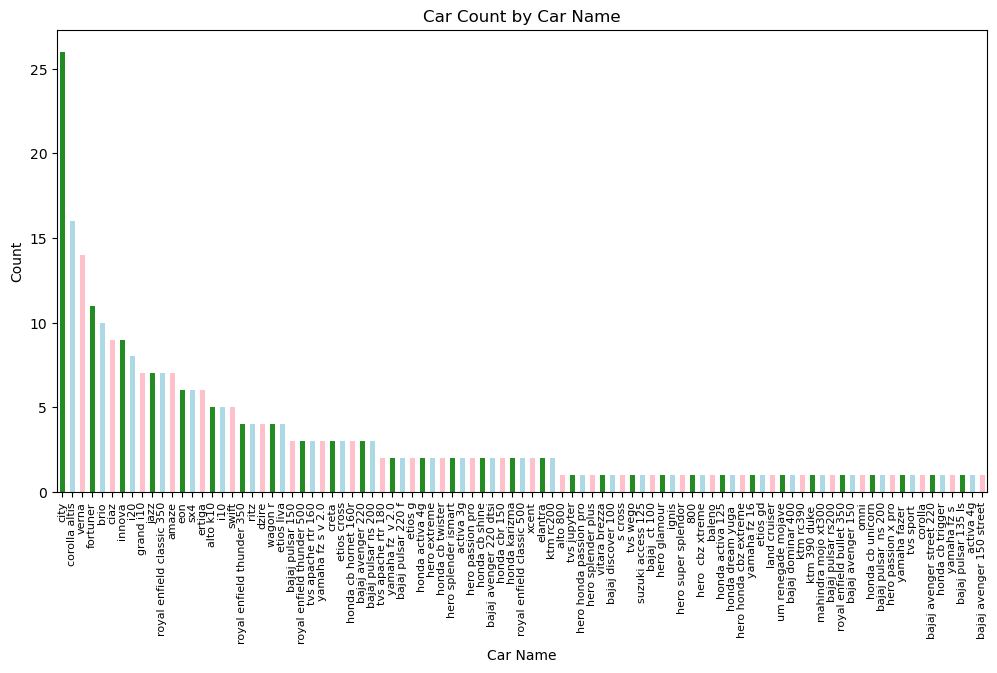

In [33]:
# Increase figure size
plt.figure(figsize= (12,6))

# Plot bar chart
car2['car_name'].value_counts().plot(kind= 'bar',
                                     color= ['forestgreen', 'lightblue', 'pink'])
# Add labels and title
plt.xlabel("Car Name")
plt.ylabel("Count")
plt.title("Car Count by Car Name")

# Font size
plt.xticks(fontsize= 8)

# Show plot
plt.show()

#### Year

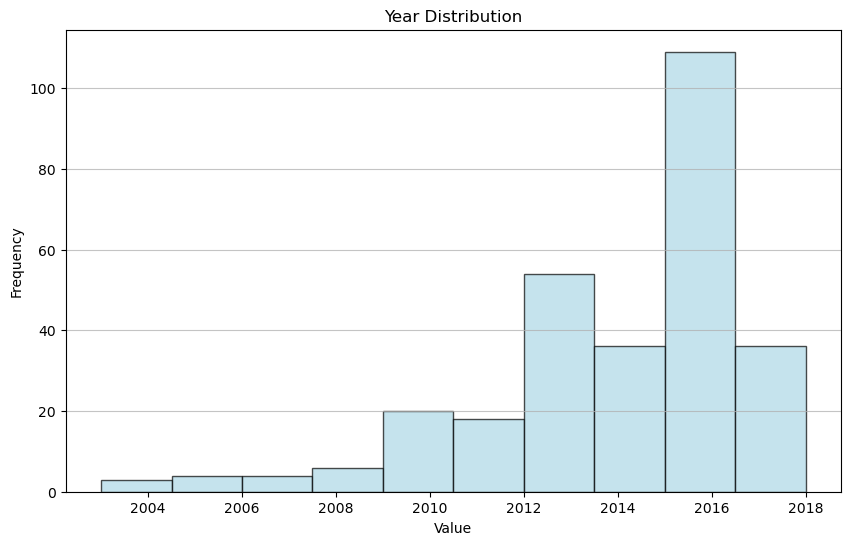

In [35]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car2['year'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# Add titles and labels
plt.title('Year Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show grid
plt.grid(axis= 'y', alpha= 0.75)

# Show plot
plt.show()

#### Selling Price

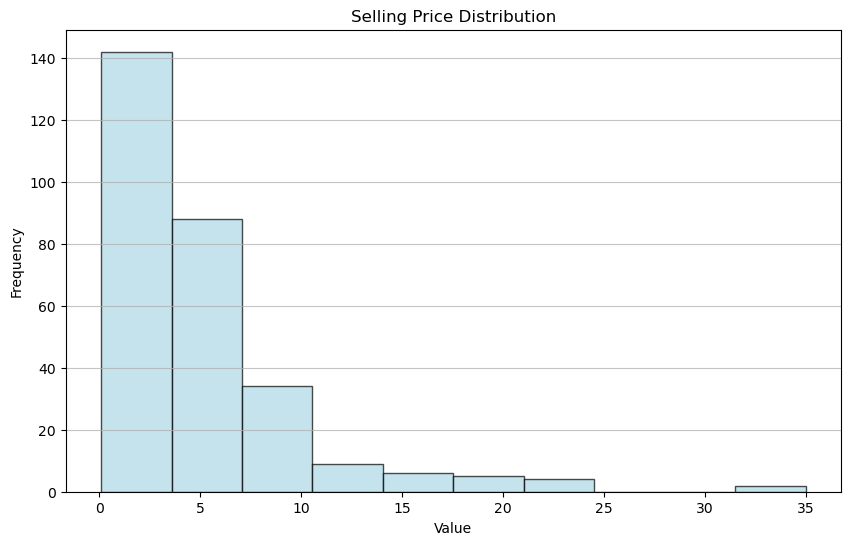

In [37]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car2['selling_price'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# add titles and labels
plt.title('Selling Price Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show grid
plt.grid(axis= 'y', alpha= 0.75)

# show plot
plt.show()

#### Present Price

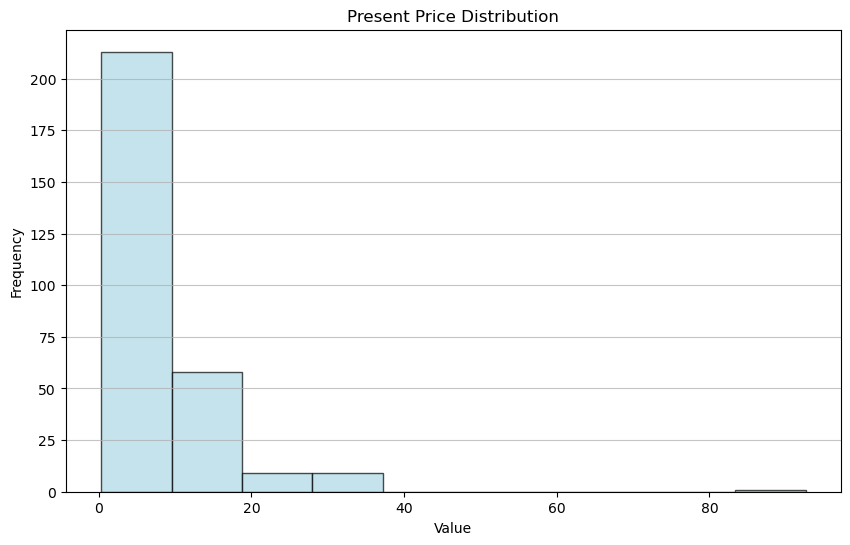

In [39]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car2['present_price'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# add titles and labels
plt.title('Present Price Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show grid
plt.grid(axis= 'y', alpha= 0.75)

# show plot
plt.show()

#### Kms Driven

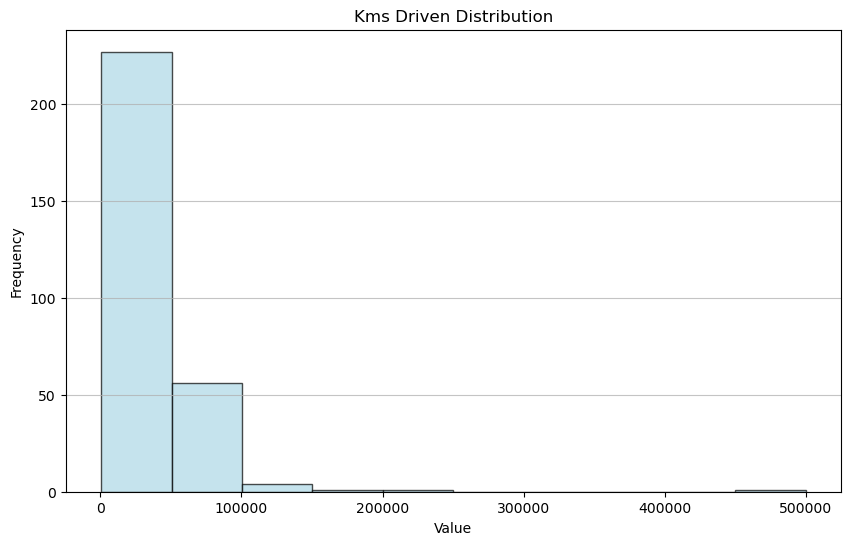

In [41]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car2['kms_driven'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# add titles and labels
plt.title('Kms Driven Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show grid
plt.grid(axis= 'y', alpha= 0.75)

# show plot
plt.show()

#### Fuel Type

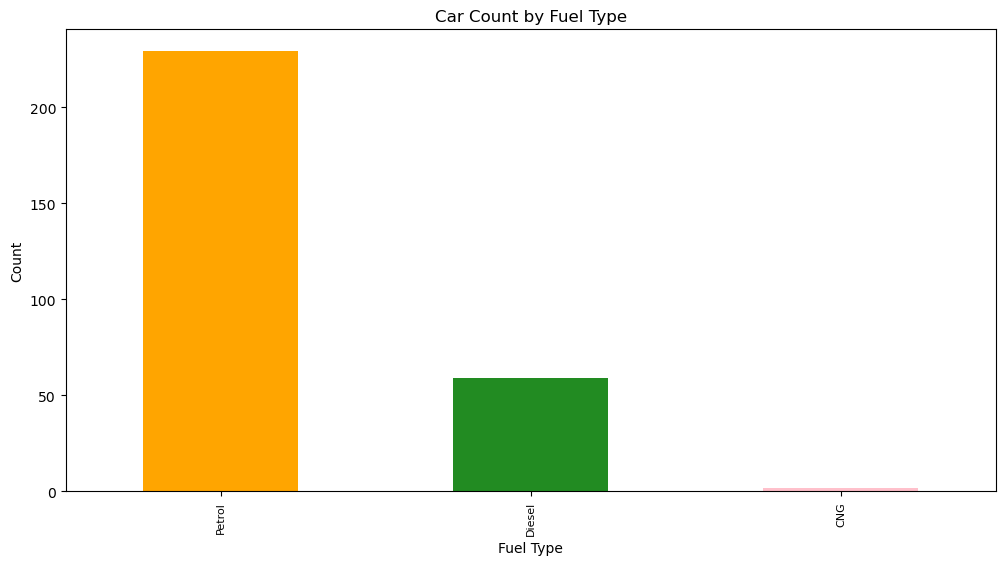

In [43]:
# Increase figure size
plt.figure(figsize= (12,6))

# Plot bar chart
car2['fuel_type'].value_counts().plot(kind= 'bar',
                                     color= ['orange', 'forestgreen', 'pink'])
# Add labels and title
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.title("Car Count by Fuel Type")

# Font size
plt.xticks(fontsize= 8)

# Show plot
plt.show()

#### Seller Type

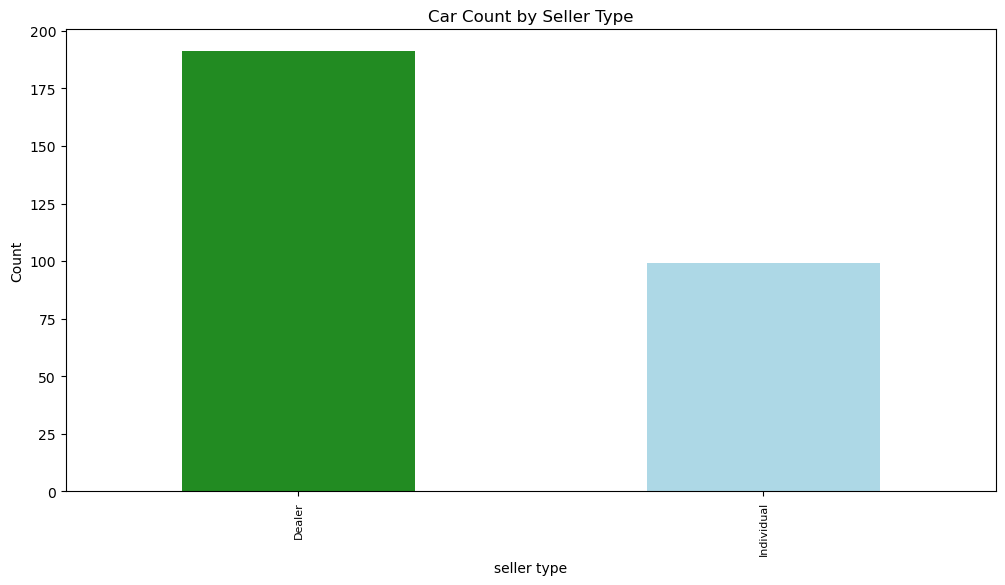

In [45]:
# Increase figure size
plt.figure(figsize= (12,6))

# Plot bar chart
car2['seller_type'].value_counts().plot(kind= 'bar',
                                     color= ['forestgreen', 'lightblue', 'pink'])
# Add labels and title
plt.xlabel("seller type")
plt.ylabel("Count")
plt.title("Car Count by Seller Type")

# Font size
plt.xticks(fontsize= 8)

# Show plot
plt.show()

#### Transmission

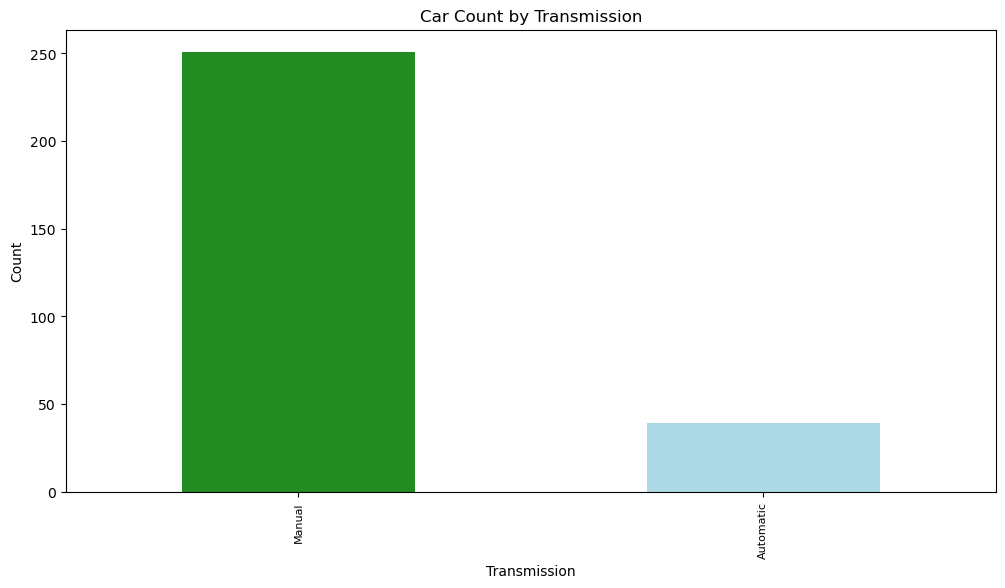

In [47]:
# Increase figure size
plt.figure(figsize= (12,6))

# Plot bar chart
car2['transmission'].value_counts().plot(kind= 'bar',
                                     color= ['forestgreen', 'lightblue', 'pink'])
# Add labels and title
plt.xlabel("Transmission")
plt.ylabel("Count")
plt.title("Car Count by Transmission")

# Font size
plt.xticks(fontsize= 8)

# Show plot
plt.show()

#### Owner

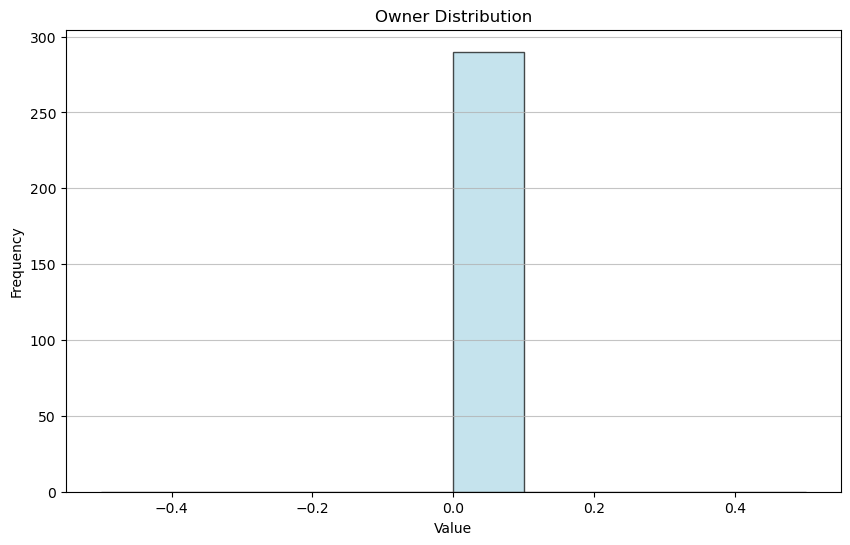

In [49]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car2['owner'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# add titles and labels
plt.title('Owner Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show grid
plt.grid(axis= 'y', alpha= 0.75)

# show plot
plt.show()

In [50]:
car2['owner'].unique().tolist()

[0]

In [51]:
car2['owner'].value_counts()

owner
0    290
Name: count, dtype: int64

In [52]:
# Owner Variable has no variability
car3 = car2.drop(columns= ['owner'], inplace= False)

car3

,car_name,year,selling_price,present_price,kms_driven,fuel_type,seller_type,transmission
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual
...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual


In [53]:
car3.dtypes

car_name          object
year               int64
selling_price    float64
present_price    float64
kms_driven         int64
fuel_type         object
seller_type       object
transmission      object
dtype: object

## Feature Engineering

#### current_year

In [56]:
# create new feature car_age
current_year = 2025 
car3['car_age'] = current_year - car3['year']

car3

,car_name,year,selling_price,present_price,kms_driven,fuel_type,seller_type,transmission,car_age
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,11
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,12
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,8
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,14
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,11
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,9
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,10
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,16
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,8


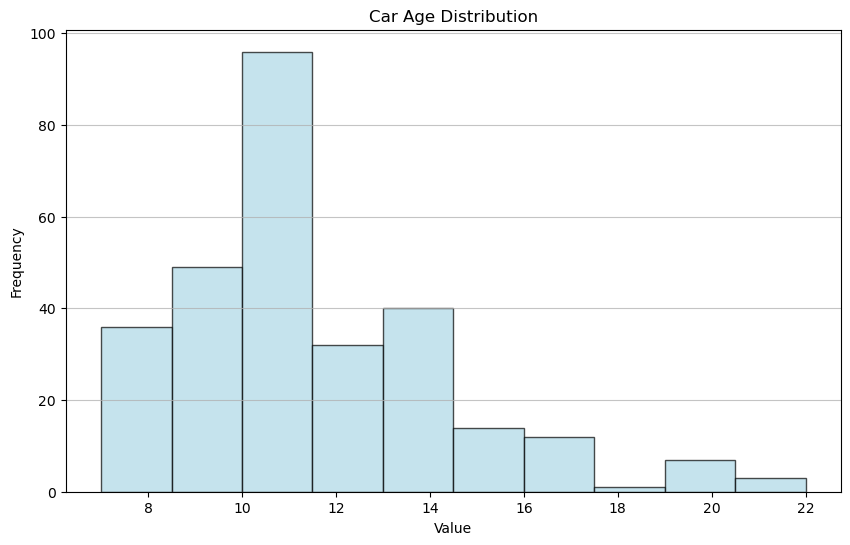

In [57]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car3['car_age'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# Add titles and labels
plt.title('Car Age Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show grid
plt.grid(axis= 'y', alpha= 0.75)

# Show plot
plt.show()

#### price_difference

In [59]:
# create new feature price_difference 
car3['price_difference'] = car3['selling_price'] - car3['present_price']

car3

,car_name,year,selling_price,present_price,kms_driven,fuel_type,seller_type,transmission,car_age,price_difference
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,11,-2.24
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,12,-4.79
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,8,-2.60
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,14,-1.30
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,11,-2.27
...,...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,9,-2.10
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,10,-1.90
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,16,-7.65
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,8,-1.00


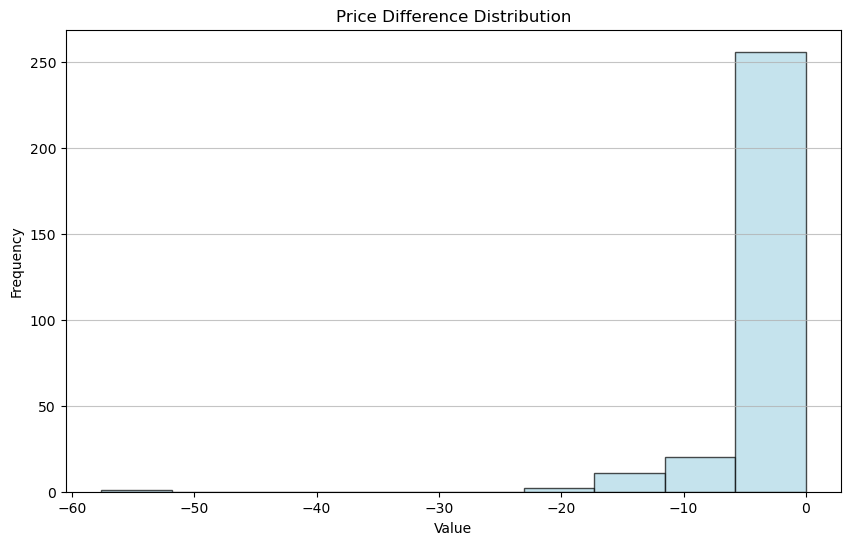

In [60]:
# Increase figure size
plt.figure(figsize= (10,6))

# Create histogram
plt.hist(car3['price_difference'], 
         bins= 10,    # adjust number of bars in the graph
         color= 'lightblue', 
         alpha= 0.7,  # transparency of graph
         edgecolor= 'black')

# Add titles and labels
plt.title('Price Difference Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show grid
plt.grid(axis= 'y', alpha= 0.75)

# Show plot
plt.show()

### Save preprocessed dataset

In [62]:
car3.to_csv('Preprocessed_CarData.csv', index = False)

In [63]:
car3.to_csv(r'C:\Users\Alex Estrada\Desktop\Preprocessed_CarData.csv', index = False)

## One Hot Encoding

In [65]:
car_encoded = pd.get_dummies(car3, 
                             columns= ['fuel_type', 'seller_type', 'transmission'], 
                             drop_first= True) # drop the first category to avoid multicollinearity

car_encoded

,car_name,year,selling_price,present_price,kms_driven,car_age,price_difference,fuel_type_Diesel,fuel_type_Petrol,seller_type_Individual,transmission_Manual
0,ritz,2014,3.35,5.59,27000,11,-2.24,False,True,False,True
1,sx4,2013,4.75,9.54,43000,12,-4.79,True,False,False,True
2,ciaz,2017,7.25,9.85,6900,8,-2.60,False,True,False,True
3,wagon r,2011,2.85,4.15,5200,14,-1.30,False,True,False,True
4,swift,2014,4.60,6.87,42450,11,-2.27,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,9,-2.10,True,False,False,True
297,brio,2015,4.00,5.90,60000,10,-1.90,False,True,False,True
298,city,2009,3.35,11.00,87934,16,-7.65,False,True,False,True
299,city,2017,11.50,12.50,9000,8,-1.00,True,False,False,True


In [66]:
# Convert only Boolean columns (T/F) to Integer (0/1) 
car_encoded[car_encoded.select_dtypes(include='bool').columns] = car_encoded.select_dtypes(include='bool').astype(int)

car_encoded

,car_name,year,selling_price,present_price,kms_driven,car_age,price_difference,fuel_type_Diesel,fuel_type_Petrol,seller_type_Individual,transmission_Manual
0,ritz,2014,3.35,5.59,27000,11,-2.24,0,1,0,1
1,sx4,2013,4.75,9.54,43000,12,-4.79,1,0,0,1
2,ciaz,2017,7.25,9.85,6900,8,-2.60,0,1,0,1
3,wagon r,2011,2.85,4.15,5200,14,-1.30,0,1,0,1
4,swift,2014,4.60,6.87,42450,11,-2.27,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,9,-2.10,1,0,0,1
297,brio,2015,4.00,5.90,60000,10,-1.90,0,1,0,1
298,city,2009,3.35,11.00,87934,16,-7.65,0,1,0,1
299,city,2017,11.50,12.50,9000,8,-1.00,1,0,0,1


#### One Hot Encoding with Car_Name

In [68]:
car_encoded_CN = pd.get_dummies(car3, 
                                columns= ['car_name','fuel_type', 'seller_type', 'transmission'], 
                                drop_first= True)
car_encoded_CN

,year,selling_price,present_price,kms_driven,car_age,price_difference,car_name_activa 3g,car_name_activa 4g,car_name_alto 800,car_name_alto k10,...,car_name_xcent,car_name_yamaha fazer,car_name_yamaha fz v 2.0,car_name_yamaha fz 16,car_name_yamaha fz s,car_name_yamaha fz s v 2.0,fuel_type_Diesel,fuel_type_Petrol,seller_type_Individual,transmission_Manual
0,2014,3.35,5.59,27000,11,-2.24,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1,2013,4.75,9.54,43000,12,-4.79,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
2,2017,7.25,9.85,6900,8,-2.60,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,2011,2.85,4.15,5200,14,-1.30,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,2014,4.60,6.87,42450,11,-2.27,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,9,-2.10,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
297,2015,4.00,5.90,60000,10,-1.90,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
298,2009,3.35,11.00,87934,16,-7.65,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
299,2017,11.50,12.50,9000,8,-1.00,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [69]:
# Convert only Boolean columns (T/F) to Integer (0/1) 
car_encoded_CN[car_encoded_CN.select_dtypes(include='bool').columns] = car_encoded_CN.select_dtypes(include='bool').astype(int)

car_encoded_CN

,year,selling_price,present_price,kms_driven,car_age,price_difference,car_name_activa 3g,car_name_activa 4g,car_name_alto 800,car_name_alto k10,...,car_name_xcent,car_name_yamaha fazer,car_name_yamaha fz v 2.0,car_name_yamaha fz 16,car_name_yamaha fz s,car_name_yamaha fz s v 2.0,fuel_type_Diesel,fuel_type_Petrol,seller_type_Individual,transmission_Manual
0,2014,3.35,5.59,27000,11,-2.24,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,2013,4.75,9.54,43000,12,-4.79,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2017,7.25,9.85,6900,8,-2.60,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,2011,2.85,4.15,5200,14,-1.30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,2014,4.60,6.87,42450,11,-2.27,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,9,-2.10,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
297,2015,4.00,5.90,60000,10,-1.90,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
298,2009,3.35,11.00,87934,16,-7.65,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
299,2017,11.50,12.50,9000,8,-1.00,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


#### save dataset

In [71]:
car_encoded.to_csv('ModelReady_CarData.csv', index = False)

In [72]:
car_encoded.to_csv(r'C:\Users\Alex Estrada\Desktop\ModelReady_CarData.csv', index = False)

In [73]:
# Car Encoded with Car Name
car_encoded_CN.to_csv('ModelReady_CarData_CN.csv', index = False)

In [74]:
car_encoded_CN.to_csv(r'C:\Users\Alex Estrada\Desktop\ModelReady_CarData_CN.csv', index = False)

## Train/Test Split

In [76]:
# Define X and y
X = car_encoded_CN.drop(columns=['selling_price','price_difference'])  # target column
y = car_encoded_CN['selling_price']

In [77]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Models: Linear Regression, Random Forest, XGBoost

In [79]:
# Train models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [80]:
# Make predictions
lr_preds = lr.predict(X_test)
rf_preds = rf.predict(X_test)

#### save train/test dataset

In [82]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [83]:
X_train.to_csv(r'C:\Users\Alex Estrada\Desktop\X_train.csv', index = False)
X_test.to_csv(r'C:\Users\Alex Estrada\Desktop\X_test.csv', index = False)

y_train.to_csv(r'C:\Users\Alex Estrada\Desktop\y_train.csv', index = False)
y_test.to_csv(r'C:\Users\Alex Estrada\Desktop\y_test.csv', index = False)

## Evaluate Models

In [85]:
# Evaluation function
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n RMSE: {rmse:.2f}\n MAE: {mae:.2f}\n R²: {r2:.2f}\n")
    return [rmse, mae, r2]

lr_scores = evaluate(y_test, lr_preds, "Linear Regression")
rf_scores = evaluate(y_test, rf_preds, "Random Forest")

Linear Regression:
 RMSE: 4.16
 MAE: 2.35
 R²: 0.57

Random Forest:
 RMSE: 3.39
 MAE: 1.10
 R²: 0.72



In [86]:
# Train and evaluate XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_scores = evaluate(y_test, xgb_preds, "XGBoost")

XGBoost:
 RMSE: 3.55
 MAE: 1.07
 R²: 0.69



## Model Comparison Table: RSME, MAE, and R²

In [88]:
# Combine results into a DataFrame
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [lr_scores[0], rf_scores[0], xgb_scores[0]],
    'MAE': [lr_scores[1], rf_scores[1], xgb_scores[1]],
    'R²': [lr_scores[2], rf_scores[2], xgb_scores[2]]
})

# Optional: Round the numbers for cleaner presentation
results_df = results_df.round(2)

# Display
results_df

,Model,RMSE,MAE,R²
0,Linear Regression,4.16,2.35,0.57
1,Random Forest,3.39,1.10,0.72
2,XGBoost,3.55,1.07,0.69


#### Random Forest gives the best perfromance
- It explains 72% of the variation in car selling price

## Q1: Can we predict the optimal selling price of a car?
Yes — the model can predict the optimal selling price of a used car with reasonable accuracy. The Random Forest model performed best, with an R² of 0.72, meaning it explains 72% of the variation in selling prices.

* Its average error (MAE) is about 1,000 USD which means predictions are on average within roughly 1,100 USD of the actual price

This level of accuracy is quite useful for pricing guidance, though it is not perfect and could be improved further with more data or tuning.

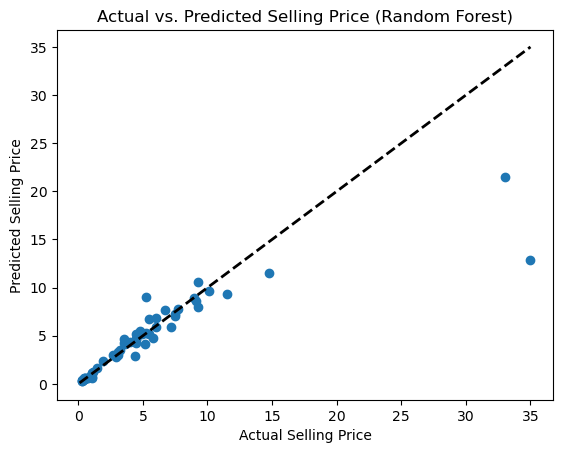

In [91]:
# Visual Comparison
plt.scatter(y_test, rf_preds)
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs. Predicted Selling Price (Random Forest)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

In [92]:
# tight diagonal line shows strong predictive accuracy and good model fit

## Q2: What Factors influence resale value?

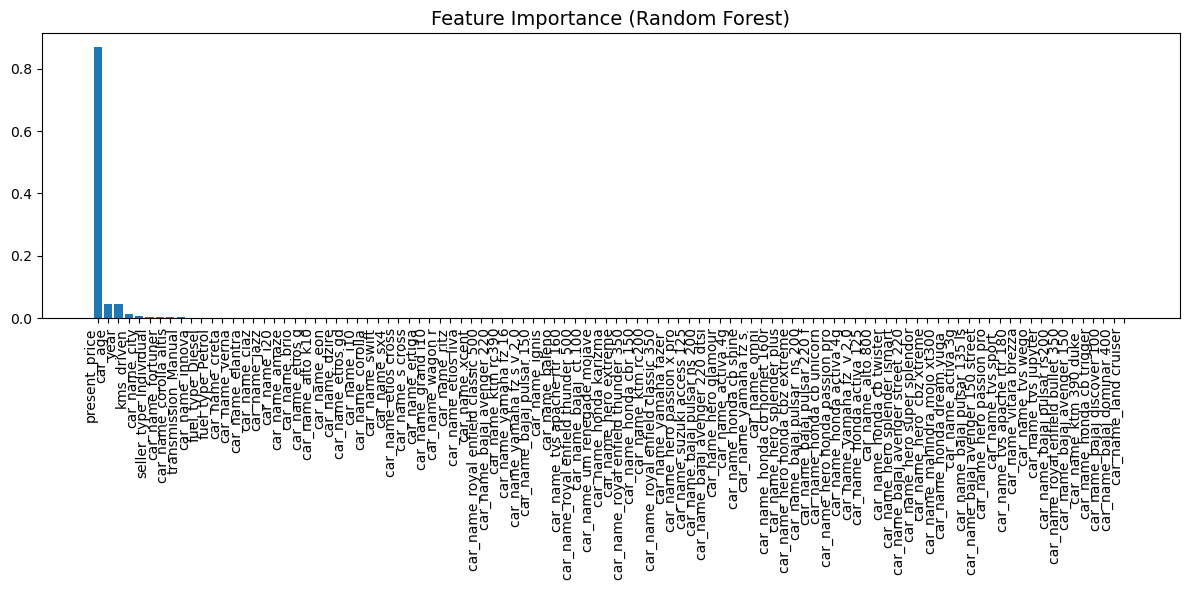

In [94]:
# Sort features by importance
importances = rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

# Set figure size
plt.figure(figsize=(12,6))

# Plot with tighter spacing and smaller labels
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), features[sorted_idx], rotation=90, ha='right', fontsize=10)

# Add title and layout adjustments
plt.title("Feature Importance (Random Forest)", fontsize= 14)
plt.tight_layout()
plt.show()

Present price, year, car age, and kms driven are the top influencers of resale value

## Q3: Which brands hold their value best?

In [97]:
# Calculate average value reatined per car brand
brand_avg = car3.groupby('car_name')[['present_price', 'selling_price']].mean()
brand_avg['value_retained_%'] = (brand_avg['selling_price'] / brand_avg['present_price']) * 100
brand_avg = brand_avg.sort_values('value_retained_%', ascending=False)
brand_avg.head(10)

,present_price,selling_price,value_retained_%
car_name,,,
vitara brezza,9.83,9.250,94.099695
bajaj avenger 150,0.80,0.750,93.750000
um renegade mojave,1.82,1.700,93.406593
tvs sport,0.52,0.480,92.307692
yamaha fz 16,0.82,0.750,91.463415
honda activa 4g,0.51,0.465,91.176471
hero passion x pro,0.55,0.500,90.909091
bajaj dominar 400,1.60,1.450,90.625000
royal enfield bullet 350,1.17,1.050,89.743590


* Vitara Brezza holds its value best, reataining 94% of its original price
* Motorcycles and scooters (Activa (91%), TVS (92%), Mojave (93%), and Bajaj (94%) models) also show strong resale value, suggesting consistent demand and low depreciation.
* This insight can help dealerhsips and online marketplaces highlight high-value retaining brands to consumers, increasing buyers and potential profit margins. 

## Q4: Do automatic cars depreciate faster than manual ones?

In [100]:
car3['depreciation'] = car3['present_price'] - car3['selling_price']
car3.groupby('transmission')['depreciation'].mean()

transmission
Automatic    5.502308
Manual       2.565100
Name: depreciation, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

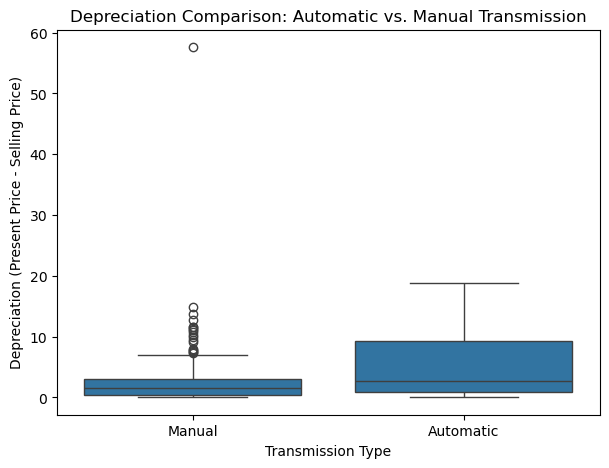

In [186]:
# Box Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=car3, x='transmission', y='depreciation')

plt.title('Depreciation Comparison: Automatic vs. Manual Transmission')
plt.xlabel('Transmission Type')
plt.ylabel('Depreciation (Present Price - Selling Price)')
plt.show

In [102]:
# Manual cars have a shorter box and lower position showing less depreciation
# Automatic cars with a taller box has a higher median and spread of depreciation

* On average, Automatic cars lose 5.50 in value, while Manual cars lose 2.57
* A boxplot confirms this pattern, showing higher median and overall depreciation in automatics.
* Therefore, Automatic cars depreciate in value faster on average

## Q5: Does high mileage = lower price?

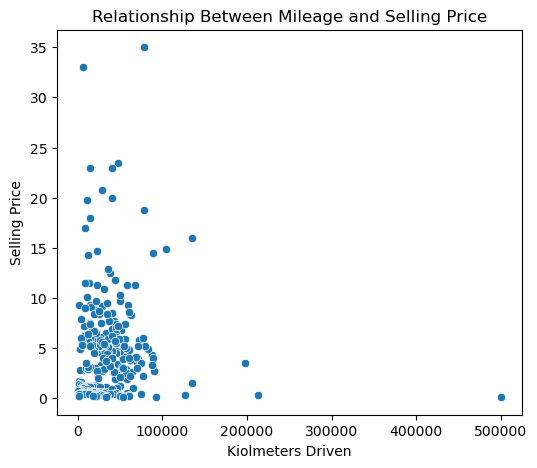

In [196]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=car3, x='kms_driven', y='selling_price')

plt.title('Relationship Between Mileage and Selling Price')
plt.xlabel('Kiolmeters Driven')
plt.ylabel('Selling Price')
plt.show()

In [106]:
corr = car3['kms_driven'].corr(car3['selling_price'])
print(f"Correlation between kms driven and selling price: {corr:.2f}")

Correlation between kms driven and selling price: 0.03


**Moderate negative correlation found. suggesting higher mileage generally leads to lower resale value.**

* The correlation between kms_driven and selling_price is 0.03, indicating almost no linear relationship.
* Most cars have mileage under 100,000 km, creating a tight concentration of values and limits the variability.
* A handful of vehicles exceed 100,000 km — including one extreme outlier at 500,000 km — but these are rare and have little effect on overall trends.
* This suggests that other factors (Car age, brand, and present price) play a much stronger role in determining resale value than mileage alone. 


## Research Questions
### Can we predict the optimal selling price of a car?
* Yes - the models demonstrate good predictive power, especially **Random Forest** which achieved:
    - R² = 0.72, meaning it explains 72% of the variation in selling prices.
    - MAE ≈ 1.10, suggesting that predicted prices are on average within $1,100 of actual prices.
* This shows that the model can provide reasonably accurate pricing guidance, especially useful for dealerships, platforms, or sellers looking to set competitive yet fair prices.
### What factors influence resale value?
* Present price (original price of the car) — strongest predictor
* Year / Car Age — newer cars retain more value
* Kms Driven — contributes slightly
* Fuel type, seller type, and transmission — have a smaller but relevant impact
    - These findings suggest that resale value is primarily influenced by the car’s original cost, age, and usage, with brand and type also playing roles.
### Which brands hold their value best?
* Vitara Brezza retains ~94% of its original price — highest among all brands
* Motorcycles and scooters also perform very well:
    - Bajaj Avenger, TVS Sport, UM Renegade Mojave, Activa 4G all retain 90%+ of value
* These high-performing brands indicate strong demand and slower depreciation, ideal for buyers prioritizing long-term value.
### Do automatic cars depreciate faster than manual ones?
* Yes
    - Automatic cars lose on average 5.50
    - Manual cars lose 2.57
* The boxplot confirms this — automatics have a higher median depreciation and more variability.
* Automatic cars depreciate more, likely due to higher upfront cost and lower resale demand in some markets.
### Does high mileage equal lower price?
* Surprisingly, not strongly in this dataset
    - Correlation = 0.03, which means almost no linear relationship
    - The scatterplot shows most cars under 100,000 km, limiting variability
    - While there's a visual trend suggesting higher mileage might reduce price, it's not strong statistically
* Mileage alone isn’t a strong determinant — other factors like age, brand, and present price weigh more heavily.